<a href="https://colab.research.google.com/github/stigsfoot/datascience-2023/blob/main/Llama2_wandb_Dialysis_Facility_Performance_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goal

Enhance the quality of dialysis care and patient experiences by providing actionable insights to healthcare providers and policymakers.

#### To do this I Fine-tune Llama 2 to create an intelligent decision support system that:


*   **Analyzes Facility Performance:** Utilizes quality measures, clinical data, and patient surveys to evaluate individual dialysis facilities' performance.
*   **Generates Personalized Recommendations**: Offers tailored recommendations for improvement based on identified weaknesses or areas of concern.
*   **Provides Comparative Analysis**: Compares facilities at state and national levels to benchmark performance and identify best practices.
*   **Visualizes Patient Experience Insights**: Processes ICH-CAHPS Survey data to visualize and interpret patient experiences, providing insights into patient satisfaction and areas for enhancing patient-provider relationships.

Follow along below and reach out to noble@byteanatom.com if you have any questions


## Installing Necessary Libraries

In [ ]:
!pip install -q -U trl transformers accelerate git+https://github.com/huggingface/peft.git
!pip install -q datasets bitsandbytes einops wandb

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.1/88.1 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 34.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 40.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 73.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 67.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 9.6

# Dataset details
U.S. Department of Health & Human Services and Centeres for Medicare & Medicaid Data can be downloaded for free on Google BigQuery and from [Kaggle](https://www.kaggle.com/datasets/bigquery/cms-medicare?select=home_health_agencies_2014). Here, I use the bigquery-public-data.cms_medicare.home_health_agencies_2014 Table for this demonstration.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls /content/drive/MyDrive/Code/llm/demos/'data'

cms_home_health_agencies_2014.csv  ICH_CAHPS_FACILITY.csv  qip23-cmpl.csv
DFC_FACILITY.csv		   ICH_CAHPS_NATIONAL.csv  qip23-ichc.csv
DFC_NATIONAL.csv		   ICH_CAHPS_STATE.csv
DFC_STATE.csv			   qip23-cdpr.csv


### Goal 1: Analyzing Dialysis Facility Performance

Task 1.1: Benchmarking Facilities Against National and State Averages
* Utilize the quality measures, ratings, and scores from the facility-level datasets to compare individual facilities against state and national averages.
* Identify high-performing and under-performing facilities and areas for improvement.

Task 1.2: Evaluating Patient Satisfaction and Experience

* Analyze patient evaluations and experiences using the ICH CAHPS datasets.
* Understand key drivers of patient satisfaction and areas where interventions may enhance patient care.

### Goal 2: Understanding Trends in Dialysis Care

Task 2.1: State-Wide Analysis

* Compare state-level data to identify regional trends and disparities.
* Analyze factors influencing state performance, such as quality of care, infection rates, and patient satisfaction.

Task 2.2: National Overview

* Analyze national averages to understand broad trends and challenges in dialysis care across the country.
* Utilize national benchmarks to set standards for facility performance and patient care.

### Goal 3: Personalized Recommendations for Improvement

* Task 3.1: Customized Insights for Individual Facilities
* Provide personalized recommendations to healthcare providers based on specific facility performance, patient satisfaction, and areas of concern.
* Develop tailored strategies to enhance care quality, patient engagement, and compliance with standards.

Task 3.2: Targeted Interventions for States

* Identify states that may benefit from targeted interventions and support.
* Propose state-specific policies or programs to address identified challenges and enhance overall dialysis care.

In [ ]:
import pandas as pd

df_dfc_facility = pd.read_csv('/content/drive/MyDrive/Code/llm/demos/data/DFC_FACILITY.csv')
df_dfc_national = pd.read_csv('/content/drive/MyDrive/Code/llm/demos/data/DFC_NATIONAL.csv')
df_dfc_state = pd.read_csv('/content/drive/MyDrive/Code/llm/demos/data/DFC_STATE.csv')
df_ich_cahps_facility = pd.read_csv('/content/drive/MyDrive/Code/llm/demos/data/ICH_CAHPS_FACILITY.csv')
df_ich_cahps_national = pd.read_csv('/content/drive/MyDrive/Code/llm/demos/data/ICH_CAHPS_NATIONAL.csv')
df_ich_cahps_state = pd.read_csv('/content/drive/MyDrive/Code/llm/demos/data/ICH_CAHPS_STATE.csv')
df_qip23_cdpr = pd.read_csv('/content/drive/MyDrive/Code/llm/demos/data/qip23-cdpr.csv')
df_qip23_cmpl = pd.read_csv('/content/drive/MyDrive/Code/llm/demos/data/qip23-cmpl.csv')
df_qip23_ichc = pd.read_csv('/content/drive/MyDrive/Code/llm/demos/data/qip23-ichc.csv')

### Analyzing the structure of DFC_Facility dataset

In [ ]:
# Displaying the first few rows of the DFC_FACILITY dataset
df_dfc_facility_head = df_dfc_facility.head()

# Listing the column names to understand the structure
df_dfc_facility_columns = df_dfc_facility.columns.tolist()

df_dfc_facility_head, df_dfc_facility_columns


(   Certification Number  Network                          Facility Name  \
 0                 12306        8            CHILDRENS HOSPITAL DIALYSIS   
 1                 12500        8                       FMC CAPITOL CITY   
 2                 12501        8                DaVita Gadsden Dialysis   
 3                 12502        8  DaVita Tuscaloosa University Dialysis   
 4                 12505        8                  DaVita PDI-Montgomery   
 
         Five Star Date  Five Star  Five Star Data Availability Code  \
 0  01Jan2016-31Dec2019        NaN                               260   
 1  01Jan2016-31Dec2019        3.0                                 1   
 2  01Jan2016-31Dec2019        4.0                                 1   
 3  01Jan2016-31Dec2019        3.0                                 1   
 4  01Jan2016-31Dec2019        3.0                                 1   
 
            Address Line 1 Address Line 2   City/Town State  ...  \
 0   1600 7TH AVENUE SOUTH            Na

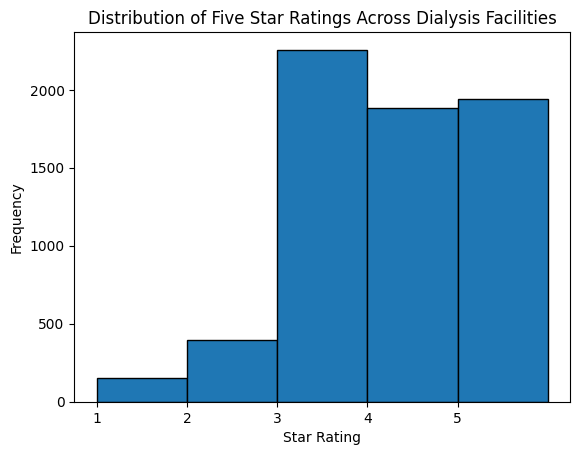

count    6627.000000
mean        3.763694
std         1.011848
min         1.000000
25%         3.000000
50%         4.000000
75%         5.000000
max         5.000000
Name: Five Star, dtype: float64


In [ ]:
import matplotlib.pyplot as plt

# Summary statistics for the 'Five Star' column
five_star_summary = df_dfc_facility['Five Star'].describe()

# Plotting a histogram to visualize the distribution of 'Five Star' ratings
plt.hist(df_dfc_facility['Five Star'], bins=range(1, 7), edgecolor='black')
plt.title('Distribution of Five Star Ratings Across Dialysis Facilities')
plt.xlabel('Star Rating')
plt.ylabel('Frequency')
plt.xticks(range(1, 6))
plt.show()

print(five_star_summary)



In [ ]:
from IPython.core.display import display, HTML #having issues with colab df...so this should suffice i guess

# Loading the DFC_NATIONAL dataset to understand its structure
df_dfc_national = pd.read_csv("/content/drive/MyDrive/Code/llm/demos/data/DFC_NATIONAL.csv")

# Loading the DFC_STATE dataset to understand its structure
df_dfc_state = pd.read_csv("/content/drive/MyDrive/Code/llm/demos/data/DFC_STATE.csv")


# Convert DataFrames to HTML
df_national_and_state_head_html = df_dfc_national_and_state_head.to_html()
df_columns_comparison_state_national_html = df_columns_comparison_state_national.to_html()

# Display HTML tables
display(HTML(df_national_and_state_head_html))
display(HTML(df_columns_comparison_state_national_html))



,DFC_NATIONAL_Columns,DFC_STATE_Columns
0,COUNTRY,State
1,Transfusion Rate (US),Transfusions- Better than expected (STATE)
2,Transfusions- Better than expected (US),Transfusions- As expected (STATE)
3,Transfusions- As expected (US),Transfusions- Worse than expected (STATE)
4,Transfusions- Worse than expected (US),Infection- Better than expected (STATE)
5,Percentage of adult HD patients with Kt/V>=1.2,Infection- As expected (STATE)
6,Percentage Of Adult PD Patients With Kt/V>=1.7,Infection- Worse than expected (STATE)
7,Percentage Of Pediatric HD Patients With Kt/V>=1.2,Percentage of adult HD patients with Kt/V>=1.2
8,Percentage Of Pediatric PD Patients With Kt/V>=1.8,Percentage Of Adult PD Patients With Kt/V>=1.7
9,Percentage Of Pediatric HD Patients With nPCR,Percentage Of Pediatric HD Patients With Kt/V>=1.2


In [ ]:
import wandb

# Start a wandb run
wandb.init(project="dialysis_analysis", name="national_summary")

# Log the national summary as a table
wandb.log({"national_summary": wandb.Table(dataframe=df_dfc_national)})



<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
# Listing the column names of the DFC_FACILITY and DFC_NATIONAL datasets to identify key quality-related columns
# Creating a DataFrame to display the columns of both DFC_FACILITY and DFC_NATIONAL datasets
df_columns_comparison = pd.DataFrame({
    'DFC_FACILITY_Columns': pd.Series(df_dfc_facility_columns),
    'DFC_NATIONAL_Columns': pd.Series(df_dfc_national_columns)
})

# Displaying the DataFrame
df_columns_comparison



,DFC_FACILITY_Columns,DFC_NATIONAL_Columns
0,Certification Number,COUNTRY
1,Network,Transfusion Rate (US)
2,Facility Name,Transfusions- Better than expected (US)
3,Five Star Date,Transfusions- As expected (US)
4,Five Star,Transfusions- Worse than expected (US)
...,...,...
113,Patient prevalent transplant waitlist data ava...,NaN
114,95% C.I. (upper limit) for PPPW,NaN
115,95% C.I. (lower limit) for PPPW,NaN
116,Number of patients for PPPW,NaN


In [ ]:
# Show the first few rows to understand the structure
df_dfc_facility.head()


,Certification Number,Network,Facility Name,Five Star Date,Five Star,Five Star Data Availability Code,Address Line 1,Address Line 2,City/Town,State,...,95% C.I. (upper limit) for SWR,95% C.I. (lower limit) for SWR,Number of patients in this facility for SWR,Standardized First Kidney Transplant Waitlist Ratio,PPPW category text,Patient prevalent transplant waitlist data availability code,95% C.I. (upper limit) for PPPW,95% C.I. (lower limit) for PPPW,Number of patients for PPPW,Percentage of Prevalent Patients Waitlisted
0,12306,8,CHILDRENS HOSPITAL DIALYSIS,01Jan2016-31Dec2019,NaN,260,1600 7TH AVENUE SOUTH,NaN,BIRMINGHAM,AL,...,1.76,0.34,34.0,0.85,As Expected,1,52.3,9.3,36.0,25.1
1,12500,8,FMC CAPITOL CITY,01Jan2016-31Dec2019,3.0,1,255 S JACKSON STREET,NaN,MONTGOMERY,AL,...,0.67,0.00,60.0,0.00,As Expected,1,22.4,2.1,118.0,7.3
2,12501,8,DaVita Gadsden Dialysis,01Jan2016-31Dec2019,4.0,1,409 SOUTH FIRST STREET,NaN,GADSDEN,AL,...,NaN,NaN,15.0,NaN,As Expected,1,38.4,1.1,52.0,7.8
3,12502,8,DaVita Tuscaloosa University Dialysis,01Jan2016-31Dec2019,3.0,1,220 15TH STREET,NaN,TUSCALOOSA,AL,...,1.38,0.10,56.0,0.47,As Expected,1,26.2,2.0,102.0,7.9
4,12505,8,DaVita PDI-Montgomery,01Jan2016-31Dec2019,3.0,1,1001 FOREST AVENUE,NaN,MONTGOMERY,AL,...,2.39,0.01,28.0,0.43,As Expected,1,25.4,1.6,96.0,6.9


National level data analysis

In [ ]:
# Show the first few rows of the national-level data
df_dfc_national.head()


,COUNTRY,Transfusion Rate (US),Transfusions- Better than expected (US),Transfusions- As expected (US),Transfusions- Worse than expected (US),Percentage of adult HD patients with Kt/V>=1.2,Percentage Of Adult PD Patients With Kt/V>=1.7,Percentage Of Pediatric HD Patients With Kt/V>=1.2,Percentage Of Pediatric PD Patients With Kt/V>=1.8,Percentage Of Pediatric HD Patients With nPCR,...,Incident Patients Transplant Waitlisting - Worse Than Expected (US),Percentage Of Prevalent Patients Waitlisted (US),Prevalent Patients Transplant Waitlisting- Better Than Expected (US),Prevalent Patients Transplant Waitlisting - As Expected (US),Prevalent Patients Transplant Waitlisting - Worse Than Expected (US),Percentage Of Patients With Hgb<10 g/dL,Percentage of patients with Hgb>12 g/dL,Infection- Better than expected (US),Infection- As expected (US),Infection- Worse than expected (US)
0,NATION,35.1,10,5557,408,96,91,89,75,89,...,160,16.6,439,6771,162,20,0,2240,4144,64


### Analyzing the rest of the data

State level data

In [ ]:
df_dfc_state.head()

,State,Transfusions- Better than expected (STATE),Transfusions- As expected (STATE),Transfusions- Worse than expected (STATE),Infection- Better than expected (STATE),Infection- As expected (STATE),Infection- Worse than expected (STATE),Percentage of adult HD patients with Kt/V>=1.2,Percentage Of Adult PD Patients With Kt/V>=1.7,Percentage Of Pediatric HD Patients With Kt/V>=1.2,...,Survival- As Expected (STATE),Survival- Worse Than Expected (STATE),Incident Patients Transplant Waitlisting- Better Than Expected (STATE),Incident Patients Transplant Waitlisting - As Expected (STATE),Incident Patients Transplant Waitlisting - Worse Than Expected (STATE),Prevalent Patients Transplant Waitlisting- Better Than Expected (STATE),Prevalent Patients Transplant Waitlisting - As Expected (STATE),Prevalent Patients Transplant Waitlisting - Worse Than Expected (STATE),Percentage Of Patients With Hgb<10 g/dL,Percentage of patients with Hgb>12 g/dL
0,AK,0,7,1,3,6,0,97.0,93.0,100.0,...,9,0,1,2,1,1,8,0,18.0,0.0
1,AL,0,133,10,39,116,0,96.0,94.0,88.0,...,162,4,2,69,3,2,171,3,23.0,0.0
2,AR,0,41,16,24,35,0,96.0,91.0,95.0,...,62,1,0,37,3,0,57,7,20.0,1.0
3,AS,0,2,0,0,0,0,NaN,NaN,NaN,...,2,0,0,0,1,0,1,1,NaN,NaN
4,AZ,0,99,3,50,68,0,97.0,94.0,98.0,...,115,6,0,83,11,0,119,6,17.0,0.0


In [ ]:
df_ich_cahps_facility.head()

,Certification Number,Network,Facility Name,Address Line 1,Address Line 2,City/Town,State,ZIP Code,County/Parish,Telephone Number,...,Linearized score of rating of the dialysis center staff,Star rating of the dialysis center staff,Lower box percent of patients-rating of the dialysis facility,Middle box percent of patients-rating of the dialysis facility,Top box percent of patients-rating of the dialysis facility,Linearized score of rating of the dialysis facility,Star rating of the dialysis facility,Total number of completed interviews from the Fall and Spring Surveys,ICH CAHPS Survey of patients' experiences star rating,Survey response rate
0,12306,8,CHILDRENS HOSPITAL DIALYSIS,1600 7TH AVENUE SOUTH,NaN,BIRMINGHAM,AL,35233,Jefferson,(205)638-9275,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,12500,8,FMC CAPITOL CITY,255 S JACKSON STREET,NaN,MONTGOMERY,AL,36104,Montgomery,(334)263-1028,...,84.0,3.0,18.0,20.0,62.0,85.0,3.0,37.0,3.0,23.0
2,12501,8,DaVita Gadsden Dialysis,409 SOUTH FIRST STREET,NaN,GADSDEN,AL,35901,Etowah,(256)547-2511,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,12502,8,DaVita Tuscaloosa University Dialysis,220 15TH STREET,NaN,TUSCALOOSA,AL,35401,Tuscaloosa,(205)345-6004,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,12505,8,DaVita PDI-Montgomery,1001 FOREST AVENUE,NaN,MONTGOMERY,AL,36106,Montgomery,(334)269-9416,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_ich_cahps_national.head()

,COUNTRY,Lower box percent of patients-nephrologists' communication and caring,Middle box percent of patients-nephrologists' communication and caring,Top box percent of patients-nephrologists' communication and caring,Linearized score of nephrologists' communication and caring,Lower box percent of patients-quality of dialysis center care and operations,Middle box percent of patients-quality of dialysis center care and operations,Top box percent of patients-quality of dialysis center care and operations,Linearized score of quality of dialysis center care and operations,Lower box percent of patients-providing information to patients,...,Lower box percent of patients-rating of the dialysis center staff,Middle box percent of patients-rating of the dialysis center staff,Top box percent of patients-rating of the dialysis center staff,Linearized score of rating of the dialysis center staff,Lower box percent of patients-rating of the dialysis facility,Middle box percent of patients-rating of the dialysis facility,Top box percent of patients-rating of the dialysis facility,Linearized score of rating of the dialysis facility,Total number of completed interviews from the Fall and Spring Surveys,Survey response rate
0,NATION,18,15,67,81,18,19,63,80,21,...,11,25,64,86,11,20,69,87,152128,22


In [ ]:
df_ich_cahps_state.head()

,STATE,Lower box percent of patients-nephrologists' communication and caring,Middle box percent of patients-nephrologists' communication and caring,Top box percent of patients-nephrologists' communication and caring,Linearized score of nephrologists' communication and caring,Lower box percent of patients-quality of dialysis center care and operations,Middle box percent of patients-quality of dialysis center care and operations,Top box percent of patients-quality of dialysis center care and operations,Linearized score of quality of dialysis center care and operations,Lower box percent of patients-providing information to patients,...,Lower box percent of patients-rating of the dialysis center staff,Middle box percent of patients-rating of the dialysis center staff,Top box percent of patients-rating of the dialysis center staff,Linearized score of rating of the dialysis center staff,Lower box percent of patients-rating of the dialysis facility,Middle box percent of patients-rating of the dialysis facility,Top box percent of patients-rating of the dialysis facility,Linearized score of rating of the dialysis facility,Total number of completed interviews from the Fall and Spring Surveys,Survey response rate
0,AK,13.0,15.0,72.0,85.0,17.0,17.0,66.0,81.0,17.0,...,8.0,22.0,70.0,89.0,11.0,14.0,75.0,89.0,189.0,26
1,AL,18.0,15.0,67.0,81.0,20.0,19.0,61.0,79.0,22.0,...,13.0,27.0,60.0,85.0,13.0,21.0,66.0,86.0,2965.0,23
2,AR,17.0,15.0,68.0,82.0,19.0,21.0,60.0,79.0,19.0,...,11.0,30.0,59.0,85.0,13.0,24.0,63.0,86.0,1443.0,23
3,AS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,AZ,22.0,17.0,61.0,77.0,20.0,21.0,59.0,77.0,22.0,...,15.0,25.0,60.0,84.0,15.0,20.0,65.0,85.0,2849.0,20


In [ ]:
df_qip23_cdpr.head()

,Facility Name,CMS Certification Number (CCN),Alternate CCN,Address,City,State,Zip Code,Network,Measure Name,Clinical Depression Screening and Follow-up Measure Score,Clinical Depression Screening and Follow-up Reason for No Score (See Footnotes File),State Average Clinical Depression Measure Score,National Average Clinical Depression Measure Score
0,032302 MARICOPA MEDICAL CTR - DIALYSIS,32302,030022,2525 E ROOSEVELT ST,PHOENIX,AZ,85008,Network 15,Clinical Depression Screening and Follow Up,10,-,10,10
1,032314 PHOENIX CHILDRENS HOSPITAL- DIALYSIS CE...,32314,033302,1920 E CAMBRIDGE RD STE 102,PHOENIX,AZ,85016,Network 15,Clinical Depression Screening and Follow Up,10,-,10,10
2,032315 GILA RIVER DIALYSIS EAST,32315,031308,565 W SEED FARM RD,SACATON,AZ,85147,Network 15,Clinical Depression Screening and Follow Up,10,-,10,10
3,032316 Banner University Medical Center Pediat...,32316,030064,PO BOX 245148,TUCSON,AZ,85724,Network 15,Clinical Depression Screening and Follow Up,No Score,1,10,10
4,032503 PHOENIX ARTIFICIAL KIDNEY CENTER (FMC),32503,-,13090 N 94TH DR STE 100,PEORIA,AZ,85381,Network 15,Clinical Depression Screening and Follow Up,10,-,10,10


In [ ]:
df_qip23_cmpl.head()

,Facility Name,CMS Certification Number (CCN),Alternate CCN,Address,City,State,Zip Code,Network,Long-term Catheter Measure Score,Long-term Catheter Reason for No Score (See Footnotes File),...,PPPW Improvement Measure Rate,PPPW Achievement Measure Rate,PPPW Measure Score,PPPW Reason for No Score (See Footnotes File),National Average PPPW Measure Score,Total Performance Score,PY2023 Payment Reduction Percentage,CMS Certification Date,"Ownership as of December 31, 2021",Date of Ownership Record Update
0,032302 MARICOPA MEDICAL CTR - DIALYSIS,32302,030022,2525 E ROOSEVELT ST,PHOENIX,AZ,85008,15,NaN,15,...,0.0353,0.0561,NaN,15,NaN,NaN,NaN,10/07/1997,Independent,10/07/1997
1,032314 PHOENIX CHILDRENS HOSPITAL- DIALYSIS CE...,32314,033302,1920 E CAMBRIDGE RD STE 102,PHOENIX,AZ,85016,15,NaN,15,...,0.2194,0.2130,NaN,15,NaN,NaN,NaN,10/22/2001,Independent,10/22/2001
2,032315 GILA RIVER DIALYSIS EAST,32315,031308,565 W SEED FARM RD,SACATON,AZ,85147,15,NaN,15,...,0.0849,0.0750,NaN,15,NaN,NaN,NaN,01/04/2006,Independent,01/04/2006
3,032316 Banner University Medical Center Pediat...,32316,030064,PO BOX 245148,TUCSON,AZ,85724,15,NaN,15,...,No Rate,No Rate,NaN,15,NaN,NaN,NaN,09/20/2012,Independent,09/20/2012
4,032503 PHOENIX ARTIFICIAL KIDNEY CENTER (FMC),32503,-,13090 N 94TH DR STE 100,PEORIA,AZ,85381,15,NaN,15,...,0.1099,0.0461,NaN,15,NaN,NaN,NaN,03/26/1979,Fresenius Medical Care,03/26/1979


In [ ]:
df_qip23_ichc.head()

,Facility Name,CMS Certification Number (CCN),Alternate CCN,Address,City,State,Zip Code,Network,Measure Name,Neph Comm and Caring Achievement Measure Rate,...,State Average Overall Rating of Dialysis Staff Measure Score,National Average Overall Rating of Dialysis Staff Measure Score,Overall Rating of Dialysis Facility Achievement Measure Rate,Overall Rating of Dialysis Facility Measure Score,State Average Overall Rating of Dialysis Facility Measure Score,National Average Overall Rating of Dialysis Facility Measure Score,ICHCAHPS Measure Score,ICH CAHPS Reason for No Score (See Footnotes File),State Average ICH CAHPS Measure Score,National Average ICH CAHPS Measure Score
0,032302 MARICOPA MEDICAL CTR - DIALYSIS,32302,030022,2525 E ROOSEVELT ST,PHOENIX,AZ,85008,15,ICH CAHPS,No Rate,...,NaN,NaN,No Rate,NaN,NaN,NaN,NaN,15,NaN,NaN
1,032314 PHOENIX CHILDRENS HOSPITAL- DIALYSIS CE...,32314,033302,1920 E CAMBRIDGE RD STE 102,PHOENIX,AZ,85016,15,ICH CAHPS,No Rate,...,NaN,NaN,No Rate,NaN,NaN,NaN,NaN,15,NaN,NaN
2,032315 GILA RIVER DIALYSIS EAST,32315,031308,565 W SEED FARM RD,SACATON,AZ,85147,15,ICH CAHPS,0.6372,...,NaN,NaN,0.8527,NaN,NaN,NaN,NaN,15,NaN,NaN
3,032316 Banner University Medical Center Pediat...,32316,030064,PO BOX 245148,TUCSON,AZ,85724,15,ICH CAHPS,No Rate,...,NaN,NaN,No Rate,NaN,NaN,NaN,NaN,15,NaN,NaN
4,032503 PHOENIX ARTIFICIAL KIDNEY CENTER (FMC),32503,-,13090 N 94TH DR STE 100,PEORIA,AZ,85381,15,ICH CAHPS,No Rate,...,NaN,NaN,No Rate,NaN,NaN,NaN,NaN,15,NaN,NaN


Merge datasets

In [ ]:
import pandas as pd

# Load facility-level data
df_facility = pd.read_csv('/content/drive/MyDrive/Code/llm/demos/data/DFC_FACILITY.csv')

# Load state-level data
df_state = pd.read_csv('/content/drive/MyDrive/Code/llm/demos/data/DFC_STATE.csv')

# Load national-level data
df_national = pd.read_csv('/content/drive/MyDrive/Code/llm/demos/data/DFC_NATIONAL.csv')


In [ ]:
# Merging the Facility and State datasets on the "State" column
df_combined_state = df_dfc_facility.merge(df_dfc_state, on="State", suffixes=('_facility', '_state'))

# Displaying the first few rows of the merged DataFrame
df_combined_state.head()



,Certification Number,Network,Facility Name,Five Star Date,Five Star,Five Star Data Availability Code,Address Line 1,Address Line 2,City/Town,State,...,Survival- As Expected (STATE),Survival- Worse Than Expected (STATE),Incident Patients Transplant Waitlisting- Better Than Expected (STATE),Incident Patients Transplant Waitlisting - As Expected (STATE),Incident Patients Transplant Waitlisting - Worse Than Expected (STATE),Prevalent Patients Transplant Waitlisting- Better Than Expected (STATE),Prevalent Patients Transplant Waitlisting - As Expected (STATE),Prevalent Patients Transplant Waitlisting - Worse Than Expected (STATE),Percentage Of Patients With Hgb<10 g/dL,Percentage of patients with Hgb>12 g/dL
0,12306,8,CHILDRENS HOSPITAL DIALYSIS,01Jan2016-31Dec2019,NaN,260,1600 7TH AVENUE SOUTH,NaN,BIRMINGHAM,AL,...,162,4,2,69,3,2,171,3,23.0,0.0
1,12500,8,FMC CAPITOL CITY,01Jan2016-31Dec2019,3.0,1,255 S JACKSON STREET,NaN,MONTGOMERY,AL,...,162,4,2,69,3,2,171,3,23.0,0.0
2,12501,8,DaVita Gadsden Dialysis,01Jan2016-31Dec2019,4.0,1,409 SOUTH FIRST STREET,NaN,GADSDEN,AL,...,162,4,2,69,3,2,171,3,23.0,0.0
3,12502,8,DaVita Tuscaloosa University Dialysis,01Jan2016-31Dec2019,3.0,1,220 15TH STREET,NaN,TUSCALOOSA,AL,...,162,4,2,69,3,2,171,3,23.0,0.0
4,12505,8,DaVita PDI-Montgomery,01Jan2016-31Dec2019,3.0,1,1001 FOREST AVENUE,NaN,MONTGOMERY,AL,...,162,4,2,69,3,2,171,3,23.0,0.0


High    3822
Low     3816
Name: Performance, dtype: int64


<Axes: xlabel='Performance', ylabel='count'>

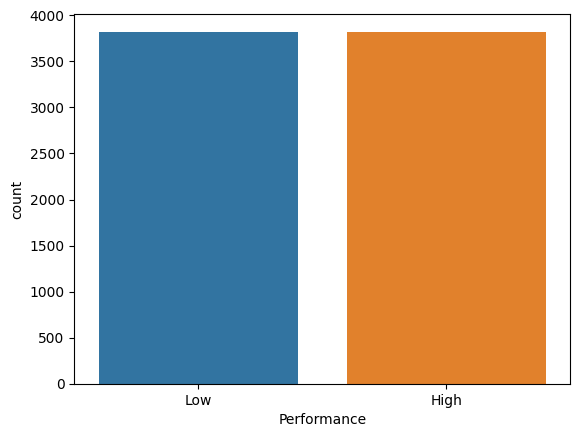

In [ ]:
# Categorizing facilities based on 'Five Star' rating
df_combined['Performance'] = ['High' if star >= 4 else 'Low' for star in df_combined['Five Star']]

# Summary of high-performing and under-performing facilities
performance_summary = df_combined['Performance'].value_counts()
print(performance_summary)

# Optional: Visualization
import seaborn as sns
sns.countplot(data=df_combined, x='Performance')


# Analyzing High-Performing and Under-Performing Facilities

In [ ]:
from IPython.display import display

# Calculate the average of the quality measure
average_kt_v = df_combined['Percent of Adult HD patients with Kt/V >= 1.2'].mean()

# Categorize facilities as high-performing or under-performing based on the average
df_combined['Performance Category'] = df_combined['Percent of Adult HD patients with Kt/V >= 1.2'].apply(
    lambda x: 'High-Performing' if x >= average_kt_v else 'Under-Performing'
)

# Display the first few rows to verify the categorization
display(df_combined[['Facility Name', 'Percent of Adult HD patients with Kt/V >= 1.2', 'Performance Category']].head())

# Save the combined dataset to a CSV file if needed
df_combined.to_csv("/content/drive/MyDrive/Code/llm/demos/dialysis_cms/out/combined_data.csv", index=False)




,Facility Name,Percent of Adult HD patients with Kt/V >= 1.2,Performance Category
0,CHILDRENS HOSPITAL DIALYSIS,NaN,Under-Performing
1,FMC CAPITOL CITY,99.0,High-Performing
2,DaVita Gadsden Dialysis,99.0,High-Performing
3,DaVita Tuscaloosa University Dialysis,97.0,High-Performing
4,DaVita PDI-Montgomery,99.0,High-Performing


# Evaluate patient satisfaction and experience using the ICH CAHPS datasets

In [ ]:
# Merge the ICH CAHPS facility dataset with the previously combined data
df_patient_satisfaction = df_combined.merge(df_ich_cahps_facility, on='Certification Number', suffixes=('', '_ich_cahps'))

# Calculate the average patient satisfaction rating
average_patient_rating = df_patient_satisfaction['Star rating of the dialysis facility'].mean()

# Display the average patient satisfaction rating
print(f"Average Patient Satisfaction Rating: {average_patient_rating}")

# You can further analyze the data, create visualizations, or perform statistical tests based on your requirements


Average Patient Satisfaction Rating: 3.8626847290640396


# Evaluate Patient Satisfaction and Experience


In [ ]:
# Merge ICH CAHPS facility data
df_combined = df_combined.merge(df_ich_cahps_facility, on='Certification Number', suffixes=('', '_ich_cahps'))


# Analyze the quality measures for individual facilities and generate actionable insights.


Here, I am categorizing Agency performance based on specific criteria, split the data into training and test sets, and convert the training set into a machine learning-compatible format.

In [ ]:
# Calculate descriptive statistics for key quality measures
quality_measures = [
    "Percent of Adult HD patients with Kt/V >= 1.2",
    "Standard Infection Ratio",
    "Hospitalization Rate (Facility)",
    "Fistula Rate (Facility)",
]

# Get statistics for each quality measure
quality_stats = df_combined[quality_measures].describe()

# Print the statistics
quality_stats


,Percent of Adult HD patients with Kt/V >= 1.2,Standard Infection Ratio,Hospitalization Rate (Facility),Fistula Rate (Facility)
count,6900.000000,6448.000000,7232.000000,7098.000000
mean,96.058116,0.410281,142.320257,59.059918
std,7.211964,0.483484,38.753476,12.062009
min,0.000000,0.000000,0.000000,0.000000
25%,96.000000,0.000000,116.875000,52.100000
50%,98.000000,0.290000,139.500000,60.000000
75%,99.000000,0.590000,165.100000,67.000000
max,100.000000,9.190000,418.800000,100.000000


# Visualize patient experiences based on ICH-CAHPS Survey data.


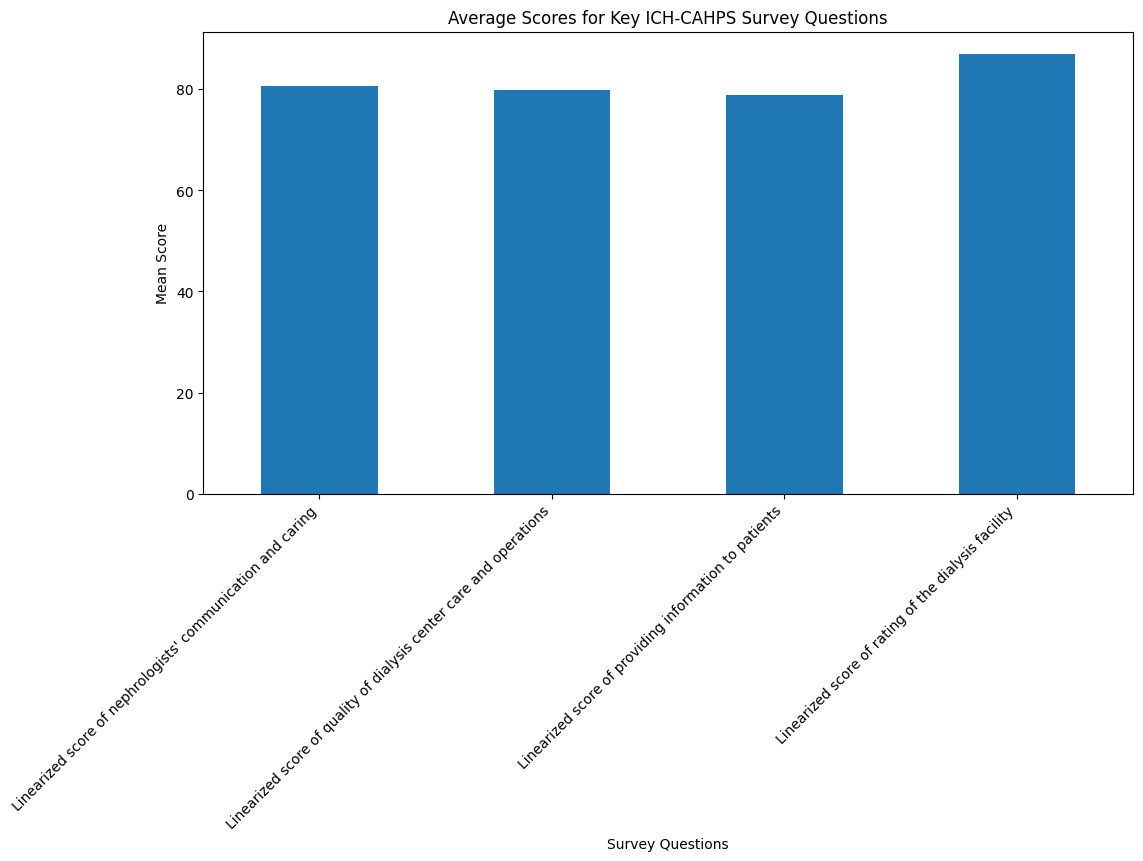

In [ ]:
import matplotlib.pyplot as plt

# Select key survey questions
survey_questions = [
    "Linearized score of nephrologists' communication and caring",
    "Linearized score of quality of dialysis center care and operations",
    "Linearized score of providing information to patients",
    "Linearized score of rating of the dialysis facility",
]

# Calculate the mean score for each selected question
survey_means = df_combined[survey_questions].mean()

# Create a bar plot for the mean scores
plt.figure(figsize=(12, 6))
survey_means.plot(kind='bar')
plt.title('Average Scores for Key ICH-CAHPS Survey Questions')
plt.ylabel('Mean Score')
plt.xlabel('Survey Questions')
plt.xticks(rotation=45, ha='right')
plt.show()


In [ ]:
# Define thresholds for categorizing performance levels
high_performance_threshold = df_combined['Percent of Adult HD patients with Kt/V >= 1.2'].quantile(0.75)
low_performance_threshold = df_combined['Percent of Adult HD patients with Kt/V >= 1.2'].quantile(0.25)

# Function to categorize performance and provide recommendations
def categorize_performance(row):
    performance_level = ''
    recommendation = ''
    kt_v_value = row['Percent of Adult HD patients with Kt/V >= 1.2']

    if kt_v_value >= high_performance_threshold:
        performance_level = 'High-Performing'
        recommendation = 'Continue current practices and explore opportunities for further enhancement.'
    elif kt_v_value <= low_performance_threshold:
        performance_level = 'Under-Performing'
        recommendation = 'Evaluate current practices, focus on patient-centered care, and consider implementing best practices from high-performing facilities.'
    else:
        performance_level = 'Average-Performing'
        recommendation = 'Identify specific areas for improvement and consider targeted interventions to enhance performance.'

    return pd.Series([performance_level, recommendation])

# Apply the function to categorize performance and provide recommendations
df_combined[['Performance Level', 'Recommendation']] = df_combined.apply(categorize_performance, axis=1)

# Display the first few rows with performance level and recommendations
colab_output = df_combined[['Facility Name', 'Percent of Adult HD patients with Kt/V >= 1.2', 'Performance Level', 'Recommendation']].head()
colab_output


,Facility Name,Percent of Adult HD patients with Kt/V >= 1.2,Performance Level,Recommendation
0,CHILDRENS HOSPITAL DIALYSIS,NaN,Average-Performing,Identify specific areas for improvement and co...
1,FMC CAPITOL CITY,99.0,High-Performing,Continue current practices and explore opportu...
2,DaVita Gadsden Dialysis,99.0,High-Performing,Continue current practices and explore opportu...
3,DaVita Tuscaloosa University Dialysis,97.0,Average-Performing,Identify specific areas for improvement and co...
4,DaVita PDI-Montgomery,99.0,High-Performing,Continue current practices and explore opportu...


In [ ]:
# Calculate state averages
state_averages = df_combined.groupby('State')['Percent of Adult HD patients with Kt/V >= 1.2'].mean().reset_index()
state_averages.rename(columns={'Percent of Adult HD patients with Kt/V >= 1.2': 'State Average'}, inplace=True)

# Merge state averages with combined dataset
df_combined = df_combined.merge(state_averages, on='State')

# Calculate national average
national_average = df_combined['Percent of Adult HD patients with Kt/V >= 1.2'].mean()

# Add national average to combined dataset
df_combined['National Average'] = national_average

# Function to categorize facility performance relative to state and national averages
def relative_performance(row):
    if row['Percent of Adult HD patients with Kt/V >= 1.2'] > row['State Average']:
        state_comparison = 'Above State Average'
    else:
        state_comparison = 'Below State Average'

    if row['Percent of Adult HD patients with Kt/V >= 1.2'] > row['National Average']:
        national_comparison = 'Above National Average'
    else:
        national_comparison = 'Below National Average'

    return pd.Series([state_comparison, national_comparison])

# Apply the function to categorize relative performance
df_combined[['State Comparison', 'National Comparison']] = df_combined.apply(relative_performance, axis=1)

# Display the first few rows with relative performance comparisons
colab_output = df_combined[['Facility Name', 'State', 'Percent of Adult HD patients with Kt/V >= 1.2', 'State Average', 'National Average', 'State Comparison', 'National Comparison']].head()
colab_output


,Facility Name,State,Percent of Adult HD patients with Kt/V >= 1.2,State Average,National Average,State Comparison,National Comparison
0,CHILDRENS HOSPITAL DIALYSIS,AL,NaN,96.426829,96.058116,Below State Average,Below National Average
1,FMC CAPITOL CITY,AL,99.0,96.426829,96.058116,Above State Average,Above National Average
2,DaVita Gadsden Dialysis,AL,99.0,96.426829,96.058116,Above State Average,Above National Average
3,DaVita Tuscaloosa University Dialysis,AL,97.0,96.426829,96.058116,Above State Average,Above National Average
4,DaVita PDI-Montgomery,AL,99.0,96.426829,96.058116,Above State Average,Above National Average


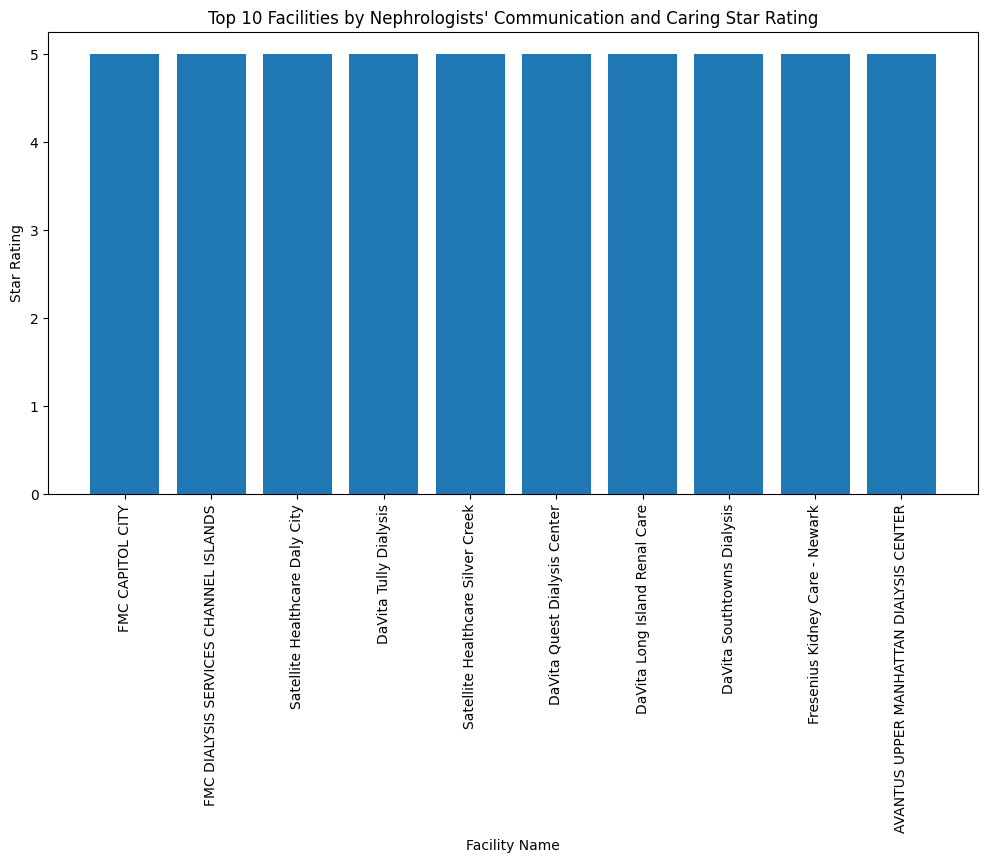

In [ ]:
import matplotlib.pyplot as plt

# Selecting the relevant columns
nephrologist_communication = df_combined[['Facility Name', "Star rating of nephrologists' communication and caring"]]

# Sorting by star rating
nephrologist_communication = nephrologist_communication.sort_values("Star rating of nephrologists' communication and caring", ascending=False)

# Selecting the top 10 facilities
top_10_communication = nephrologist_communication.head(10)

# Plotting the bar plot
plt.figure(figsize=(12,6))
plt.bar(top_10_communication['Facility Name'], top_10_communication["Star rating of nephrologists' communication and caring"])
plt.xlabel('Facility Name')
plt.ylabel('Star Rating')
plt.title('Top 10 Facilities by Nephrologists\' Communication and Caring Star Rating')
plt.xticks(rotation=90)
plt.show()


# Actionable insights through fine-tuning

Train test split

In [ ]:
from sklearn.model_selection import train_test_split

# Splitting the merged dataset into training and testing sets (80% training, 20% testing)
train_df, test_df = train_test_split(df_combined, test_size=0.2, random_state=42)

# Displaying the shape of the training and testing DataFrames to verify the split
print("Training DataFrame Shape:", train_df.shape)
print("Testing DataFrame Shape:", test_df.shape)
train_df.head(10)


Training DataFrame Shape: (6110, 211)
Testing DataFrame Shape: (1528, 211)


,Certification Number,Network,Facility Name,Five Star Date,Five Star,Five Star Data Availability Code,Address Line 1,Address Line 2,City/Town,State,...,Total number of completed interviews from the Fall and Spring Surveys,ICH CAHPS Survey of patients' experiences star rating,Survey response rate,Performance Category,Performance Level,Recommendation,State Average,National Average,State Comparison,National Comparison
4385,312707,3,Satellite Wellbound of Cherry Hill,01Jan2016-31Dec2019,NaN,260,1845 ROUTE 70 EAST SUITE A,NaN,CHERRY HILL,NJ,...,NaN,NaN,NaN,Under-Performing,Average-Performing,Identify specific areas for improvement and co...,96.919355,96.058116,Below State Average,Below National Average
5166,362602,9,DaVita Fairfield Dialysis,01Jan2016-31Dec2019,4.0,1,1210 HICKS BLVD,NaN,FAIRFIELD,OH,...,NaN,NaN,NaN,High-Performing,Average-Performing,Identify specific areas for improvement and co...,96.363014,96.058116,Above State Average,Above National Average
421,52541,18,DaVita Palm Springs Dialysis,01Jan2016-31Dec2019,4.0,1,1061 N. Indian Canyon Drive,NaN,Palm Springs,CA,...,37.0,2.0,19.0,Under-Performing,Under-Performing,"Evaluate current practices, focus on patient-c...",96.255217,96.058116,Below State Average,Below National Average
505,52675,17,DaVita East Bay Peritoneal Dialysis Center,01Jan2016-31Dec2019,3.0,1,13939 E 14TH STREET STE 110,NaN,SAN LEANDRO,CA,...,NaN,NaN,NaN,Under-Performing,Average-Performing,Identify specific areas for improvement and co...,96.255217,96.058116,Below State Average,Below National Average
6780,672683,14,FKC Beaumont,01Jan2016-31Dec2019,3.0,1,50 North 11th Street,NaN,Beaumont,TX,...,31.0,2.0,17.0,Under-Performing,Under-Performing,"Evaluate current practices, focus on patient-c...",96.281977,96.058116,Below State Average,Below National Average
3159,192712,13,FMCNA - SOUTH MONROE,01Jan2016-31Dec2019,3.0,1,1710 SOUTHERN AVE,NaN,MONROE,LA,...,34.0,3.0,20.0,Under-Performing,Under-Performing,"Evaluate current practices, focus on patient-c...",96.701754,96.058116,Below State Average,Below National Average
4248,312557,3,FMC Lakewood,01Jan2016-31Dec2019,5.0,1,Seagull Shopping Plaza,1328 River Avenue Ste 16,LAKEWOOD,NJ,...,NaN,NaN,NaN,High-Performing,High-Performing,Continue current practices and explore opportu...,96.919355,96.058116,Above State Average,Above National Average
1858,112524,6,US Renal Care Dalton Dialysis,01Jan2016-31Dec2019,3.0,1,1009 PROFESSIONAL BLVD,NaN,DALTON,GA,...,43.0,4.0,28.0,High-Performing,Average-Performing,Identify specific areas for improvement and co...,94.190769,96.058116,Above State Average,Above National Average
506,52676,17,DCI UNIVERSITY DIALYSIS CLINIC,01Jan2016-31Dec2019,3.0,1,1771 STOCKTON BLVD,NaN,SACRAMENTO,CA,...,34.0,4.0,26.0,Under-Performing,Under-Performing,"Evaluate current practices, focus on patient-c...",96.255217,96.058116,Below State Average,Below National Average
7238,492641,5,RAI - SOUTH CHURCH-SMITHFIELD,01Jan2016-31Dec2019,4.0,1,1812-C S CHURCH ST,NaN,SMITHFIELD,VA,...,NaN,NaN,NaN,High-Performing,Average-Performing,Identify specific areas for improvement and co...,96.767196,96.058116,Above State Average,Above National Average


In [ ]:
from datasets import Dataset,DatasetDict
train_dataset_dict = DatasetDict({
    "train": Dataset.from_pandas(train_df),
    #todo add validation and test when i get the chance
})

**Loading Llama-2-7B model with the quantized for my mac (bits and bytes)**

Having issues with my local Llama2 model so using one on HF

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, AutoTokenizer

model_name = "TinyPixel/Llama-2-7B-bf16-sharded"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    trust_remote_code=True
)
model.config.use_cache = False

Loading checkpoint shards:   0%|          | 0/14 [00:00<?, ?it/s]

**Loading tokenizer**

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token

Using HF transformers pipeline for text generation to:



1.  Analyze Facility Performance
 * Input: A description or key features of a dialysis facility, including quality measures, clinical data, etc.
 * Action: Use the model to generate insights or evaluations about the facility's performance.
2.  Generate Personalized Recommendations
 * Input: Details of multiple facilities, along with state and national averages.
 * Action: Use the model to generate comparative analysis, identifying best practices or areas where a facility might lag behind others.
3.  Provide Comparative Analysis
 * Input: Details of multiple facilities, along with state and national averages.
 * Action: Use the model to generate comparative analysis, identifying best practices or areas where a facility might lag behind others.
4.  Visualize Patient Experience Insights
 * Input: ICH-CAHPS Survey data or specific questions and responses related to patient experiences.
 * Action: Use the model to generate interpretations or visualizations of patient satisfaction and areas for enhancement.



In [ ]:
import transformers
import torch

pipeline = transformers.pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    torch_dtype=torch.bfloat16,
    trust_remote_code=True,
    device_map="auto",
)

# Prompts for specific tasks
prompts = [
    "Facility ABC with 95% Kt/V >= 1.2, 5-Star rating, and 90% patient satisfaction -> Analyze Performance:",
    "Facility XYZ with 75% Kt/V >= 1.2, 3-Star rating, and 70% patient satisfaction -> Provide Recommendations:",
    "Comparative analysis of Facility ABC and Facility XYZ in terms of Kt/V, Star rating, and patient satisfaction ->:",
    "ICH-CAHPS Survey for Facility ABC with 80% positive rating on nephrologists' communication -> Interpret Patient Experiences:"
]

sequences = pipeline(prompts, max_length=200, do_sample=True, top_k=10, num_return_sequences=1, eos_token_id=tokenizer.eos_token_id)

for seq in sequences:
    print(f"Result: {seq[0]['generated_text']}")


Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1270: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation )
  warnings.warn(


Result: Facility ABC with 95% Kt/V >= 1.2, 5-Star rating, and 90% patient satisfaction -> Analyze Performance: Kt/V >1.2, patient satisfaction > 90%.
The 4-Star rating is awarded to facilities with the lowest risk of patient harm and death, according to the CMS website.
“I’m proud for our organization as a whole to be the first in Texas to earn the 5-Star rating,” said John B. Connelly, CEO of Baylor Scott & White Health.
“While this recognition is a significant honor, our commitment is to always do the right thing for the patients we serve and to be their choice for care,” said Connelly. “I want to thank our physicians and associates for their dedication to high-quality patient care and their commitment to our mission of making healthcare easier.”
Result: Facility XYZ with 75% Kt/V >= 1.2, 3-Star rating, and 70% patient satisfaction -> Provide Recommendations:
• 12-week plan:
11/9, 11/16, 11/23, and 11/30: Meet with facility to develop a 12-week plan that will include the following el

Set up the configuration for LoRA, specifying the required values for alpha, dropout, rank (r), and the target modules for adaptation.

In [ ]:
from peft import LoraConfig

lora_alpha = 16
lora_dropout = 0.1
lora_r = 64

peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_r,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=["q_proj","v_proj"]
)

# Load the trainer

Here we will use the [`SFTTrainer` from TRL library](https://huggingface.co/docs/trl/main/en/sft_trainer) that gives a wrapper around transformers `Trainer` to easily fine-tune models on instruction based datasets using PEFT adapters. Let's first load the training arguments below.

In [ ]:
from transformers import TrainingArguments

output_dir = "/content/drive/MyDrive/Code/llm/demos/dialysis_cms/out_model"
per_device_train_batch_size = 4
gradient_accumulation_steps = 4
optim = "paged_adamw_32bit"
save_steps = 10
logging_steps = 1
learning_rate = 2e-4
max_grad_norm = 0.3
max_steps = 120
warmup_ratio = 0.03
lr_scheduler_type = "constant"

training_arguments = TrainingArguments(
    output_dir=output_dir,
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    optim=optim,
    save_steps=save_steps,
    logging_steps=logging_steps,
    learning_rate=learning_rate,
    fp16=True,
    max_grad_norm=max_grad_norm,
    max_steps=max_steps,
    warmup_ratio=warmup_ratio,
    group_by_length=True,
    lr_scheduler_type=lr_scheduler_type,
)

Before we pass everything to the trainer, lets create a single text column

In [ ]:
# Load the combined data
file_path = "/content/drive/MyDrive/Code/llm/demos/dialysis_cms/out/combined_data.csv"
df = pd.read_csv(file_path)

# Combine relevant columns into a single text column
columns_to_combine = ['Facility Name', 'Five Star', 'Performance Category']
df['text_data'] = df[columns_to_combine].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)

# Split the data into training and testing datasets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Convert to Hugging Face Dataset
from datasets import Dataset, DatasetDict
train_dataset_dict = DatasetDict({
    "train": Dataset.from_pandas(train_df),
})

# Trainer setup
from trl import SFTTrainer

max_seq_length = 512

trainer = SFTTrainer(
    model=model,
    train_dataset=train_dataset_dict['train'],
    peft_config=peft_config,
    dataset_text_field="text_data",
    max_seq_length=max_seq_length,
    tokenizer=tokenizer,
    args=training_arguments,
)


/usr/local/lib/python3.10/dist-packages/peft/utils/other.py:122: FutureWarning: prepare_model_for_int8_training is deprecated and will be removed in a future version. Use prepare_model_for_kbit_training instead.
  warnings.warn(


Map:   0%|          | 0/6110 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:207: UserWarning: You passed a tokenizer with `padding_side` not equal to `right` to the SFTTrainer. This might lead to some unexpected behaviour due to overflow issues when training a model in half-precision. You might consider adding `tokenizer.padding_side = 'right'` to your code.
  warnings.warn(


**Pre-process the model by upcasting the layer norms to float32 for more stable training**


In [ ]:
for name, module in trainer.model.named_modules():
    if "norm" in name:
        module = module.to(torch.float32)

## Train the model

In [ ]:
trainer.train()

You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
1,2.450300
2,3.359600
3,3.323100
4,3.344600
5,3.307500
6,3.191100
7,2.896300
8,2.891500
9,3.076100
10,2.685300


TrainOutput(global_step=120, training_loss=1.6834798542161782, metrics={'train_runtime': 459.1193, 'train_samples_per_second': 4.182, 'train_steps_per_second': 0.261, 'total_flos': 821921733672960.0, 'train_loss': 1.6834798542161782, 'epoch': 0.31})

## Train the model then logging out results

In [ ]:
import wandb
from transformers import TrainingArguments

# Initialize wandb
wandb_run = wandb.init(project="dialysis_cms_analysis")

# Define the metrics to log (if not automatically handled by the trainer)
def compute_metrics(p):
    return {
        "loss": p.loss,
        "perplexity": torch.exp(p.loss),
        # Add other custom metrics if needed
    }

# Set up the TrainingArguments to use wandb
training_arguments = TrainingArguments(
    report_to='wandb',  # Enable logging to wandb
    output_dir="/content/drive/MyDrive/Code/llm/demos/dialysis_cms/out_model",
    per_device_train_batch_size=4,
    gradient_accumulation_steps=4,
    optim="paged_adamw_32bit",
    save_steps=10,
    logging_steps=1,
    learning_rate=2e-4,
    fp16=True,
    max_grad_norm=0.3,
    max_steps=120,
    warmup_ratio=0.03,
    group_by_length=True,
    lr_scheduler_type="constant",
)

# Create the trainer and train the model
trainer = SFTTrainer(
    model=model,
    train_dataset=train_dataset_dict['train'],
    peft_config=peft_config,
    dataset_text_field="text_data",
    max_seq_length=512,
    tokenizer=tokenizer,
    args=training_arguments,
    compute_metrics=compute_metrics,  # Add this line to log custom metrics
)
training_results = trainer.train()

# Optionally, you can save the model to wandb
trainer.save_model(output_dir=wandb.run.dir)

# Finish the wandb run
wandb_run.finish()


train/epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
train/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/loss,▆█▇▆▆▅▅▄▄▃▃▄▄▄▅▄▅▃▄▆▅▃▃▃▃▂▂▃▃▂▅▅▄▁▄▄▄▄▄▃
train/total_flos,▁
train/train_loss,▁
train/train_runtime,▁
train/train_samples_per_second,▁
train/train_steps_per_second,▁
train/epoch,0.31
train/global_step,120


/usr/local/lib/python3.10/dist-packages/peft/utils/other.py:122: FutureWarning: prepare_model_for_int8_training is deprecated and will be removed in a future version. Use prepare_model_for_kbit_training instead.
  warnings.warn(


Map:   0%|          | 0/6110 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:207: UserWarning: You passed a tokenizer with `padding_side` not equal to `right` to the SFTTrainer. This might lead to some unexpected behaviour due to overflow issues when training a model in half-precision. You might consider adding `tokenizer.padding_side = 'right'` to your code.
  warnings.warn(


Step,Training Loss
1,2.450300
2,3.359600
3,3.323000
4,3.342800
5,3.306000
6,3.186500
7,2.894200
8,2.892700
9,3.078800
10,2.690600


train/epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
train/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/loss,▅█▇▆▆▅▄▃▃▃▂▃▃▄▄▃▅▄▂▃▂▂▂▁▁▁▁▁▁▂▃▃▂▄▃▂▂▂▂▁
train/total_flos,▁
train/train_loss,▁
train/train_runtime,▁
train/train_samples_per_second,▁
train/train_steps_per_second,▁
train/epoch,0.31
train/global_step,120


In [ ]:
lst_test_data = list(test_df['text_data'])

In [ ]:
len(lst_test_data)

1528

In [ ]:
sample_size = 25
lst_test_data_short = lst_test_data[:sample_size]

In [ ]:
import transformers

# Creating a text-generation pipeline with the fine-tuned model and specific parameters
pipeline = transformers.pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    torch_dtype=torch.float16,  # Using float16 data type
    trust_remote_code=True,
    device_map="auto",
)

# Generating responses for the short test data (lst_test_data_short)
sequences = pipeline(
    lst_test_data_short,
    max_length=100,  # Limiting the maximum length of generated text
    do_sample=True,
    top_k=10,
    num_return_sequences=1,
    eos_token_id=tokenizer.eos_token_id,
)

# Printing the generated responses with index
for ix, seq in enumerate(sequences):
    print(ix, seq[0]['generated_text'])


0 WellBound of San Jose 2.0 Under-Performing High-Performing High-Performing 4.00 2.0 Under-Performing High-Performing 3.50 1.9 Under-Performing High-Performing 3.00 2.1 Under-Performing High-Performing 3.00 2.5 Under-Performing Under-Performing
1 HUNTINGTON HOSPITAL 1.0 Under-Performing - Under-Performing Rural Critical Access Hospital 5.0 High-Performing High-Performing 4.0 High-Performing High-Performing 3.0 High-Performing High-Performing
DDIALYSIS PARTNERS OF TUSCUMBIA 5.0 High-Performing High
2 DaVita Cobblestone Dialysis 5.0 High-Performing Under-Performing Under-Performing 4.00 3.00 4.0 0.58 0.16 3.00 NA NA
DCI DIALYTICS CENTER 4.0 High-Performing High-Performing High-Performing 3.00 3.00
3 DaVita Melrose Park Dialysis nan Under-Performing - Dialysis - - High-Performing - Under-Performing 0 4. sierp. 2006 US RENAL CARE - SAN BERNARDINO COUNTY DIALYSIS CENTER 3.0 Under-Performing - Dialysis - - High-Performing - Under-Performing 0 4. c
4 FKC Corpus Christi Bayside nan Under-Perf

In [ ]:
import transformers

def extract_insight(text):
    # Define a function to extract the relevant part of the text, which could vary based on your specific prompts and responses
    return text.split("Insight:")[1].strip() if "Insight:" in text else text

pipeline = transformers.pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    torch_dtype=torch.float16,
    trust_remote_code=True,
    device_map="auto",
)

combined_data_df = pd.read_csv(file_path)

# Sample 4 facility names
sample_facility_names = combined_data_df['Facility Name'].sample(4).tolist()

# Create specific prompts
prompts = [
    f"Analyze Facility Performance for Facility Name {sample_facility_names[0]} ->:",
    f"Provide Personalized Recommendations for Facility Name {sample_facility_names[1]} ->:",
    f"Compare Facility Name {sample_facility_names[2]} with State Average ->:",
    f"Visualize Patient Experience for Facility Name {sample_facility_names[3]} ->:",
]


sequences = pipeline(
    prompts,
    max_length=100,
    do_sample=True,
    top_k=10,
    num_return_sequences=1,
    eos_token_id=tokenizer.eos_token_id,
)

insights = []
for ix, seq in enumerate(sequences):
    insight = extract_insight(seq[0]['generated_text'])
    print(f"Prompt {ix}: {prompts[ix]}")
    print(f"Insight: {insight}")
    insights.append(insight)


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


Prompt 0: Analyze Facility Performance for Facility Name WellBound of San Jose ->:
Insight: Analyze Facility Performance for Facility Name WellBound of San Jose ->: 5. hopefully no deficiencies are cited. 6. If there are deficiencies, then: a. 7. Review each deficiency with the facility staff. b. 8. Ask if the deficiency is being corrected. If yes, ask when it will be corrected. c. 9. Ask if there is anything that needs to be done differently.
Prompt 1: Provide Personalized Recommendations for Facility Name HUNTINGTON HOSPITAL ->:
Insight: Provide Personalized Recommendations for Facility Name HUNTINGTON HOSPITAL ->: 3. everybody is very friendly and helpful. 730 5TH AVENUE SOUTH 2.0 High-Performing High-Risk Newborn Nursery 4.0 High-Performing Diabetes Care 4.0 High-Performing Heart Failure 3.0 High-Performing P
Prompt 2: Compare Facility Name DaVita Cobblestone Dialysis with State Average ->:
Insight: Compare Facility Name DaVita Cobblestone Dialysis with State Average ->: 3. nobody 

In [ ]:
import pandas as pd

# Sample code to generate responses (you can replace this with your actual code)
def generate_responses(prompts):
    responses = [f"Response for: {prompt}" for prompt in prompts]
    return responses

# Generate responses using your fine-tuned model
responses = generate_responses(prompts)

# Create a DataFrame with prompts and responses
results_df = pd.DataFrame({
    'Prompt': prompts,
    'Response': responses
})

# Display the DataFrame as a table in Colab
results_df


# Evaluation

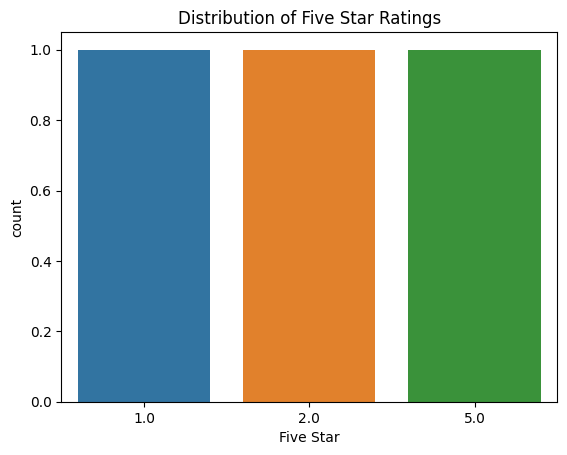

,Facility Name,Five Star,Performance Category,Generated Insights
0,WellBound of San Jose,2.0,Under-Performing,Analyze Facility Performance for Facility Name...
1,HUNTINGTON HOSPITAL,1.0,Under-Performing,Provide Personalized Recommendations for Facil...
2,DaVita Cobblestone Dialysis,5.0,High-Performing,Compare Facility Name DaVita Cobblestone Dialy...
3,DaVita Melrose Park Dialysis,NaN,Under-Performing,Visualize Patient Experience for Facility Name...


In [ ]:
# Extract the insights from the sequences
insights = [seq[0]['generated_text'] for seq in sequences]

# Select a subset of the DataFrame matching the number of prompts
sample_size = len(prompts)
df_evaluate = test_df.iloc[:sample_size][['Facility Name', 'Five Star', 'Performance Category']]
df_evaluate = df_evaluate.reset_index(drop=True)
df_evaluate['Generated Insights'] = insights

# Visualization (e.g., a bar plot of the 'Five Star' rating)
sns.countplot(data=df_evaluate, x='Five Star')
plt.title('Distribution of Five Star Ratings')
plt.show()

# Display the DataFrame
df_evaluate


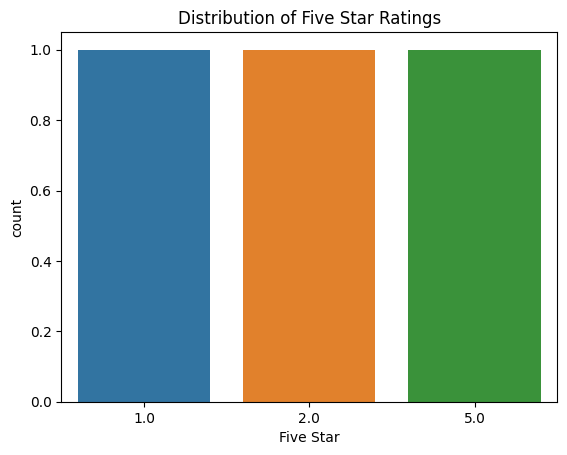

,Facility Name,Five Star,Performance Category,Generated Insights
0,WellBound of San Jose,2.0,Under-Performing,Analyze Facility Performance for Facility Name...
1,HUNTINGTON HOSPITAL,1.0,Under-Performing,Provide Personalized Recommendations for Facil...
2,DaVita Cobblestone Dialysis,5.0,High-Performing,Compare Facility Name DaVita Cobblestone Dialy...
3,DaVita Melrose Park Dialysis,NaN,Under-Performing,Visualize Patient Experience for Facility Name...


In [ ]:
# Assuming 'insights' contains the insights generated by the model for the given prompts

# Create a DataFrame for evaluation
df_evaluate = test_df.iloc[:len(insights)][['Facility Name', 'Five Star', 'Performance Category']]
df_evaluate = df_evaluate.reset_index(drop=True)
df_evaluate['Generated Insights'] = insights

# Visualization (e.g., a bar plot of the 'Five Star' rating)
sns.countplot(data=df_evaluate, x='Five Star')
plt.title('Distribution of Five Star Ratings')
plt.show()

# Display the DataFrame
df_evaluate


# Distributiion of Perf Categories

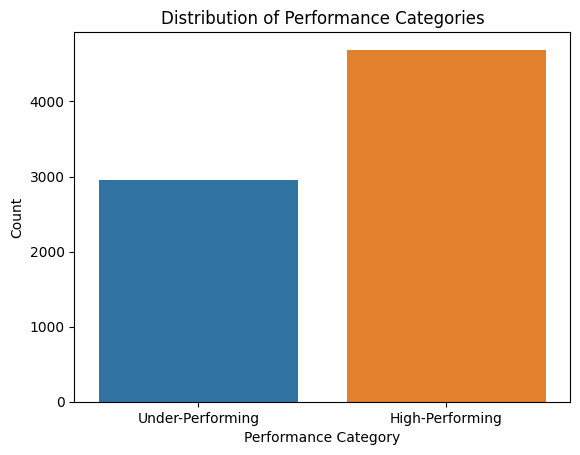

In [ ]:
sns.countplot(data=df_combined, x='Performance Category')
plt.title('Distribution of Performance Categories')
plt.xlabel('Performance Category')
plt.ylabel('Count')
plt.show()


# Five star ratings distro

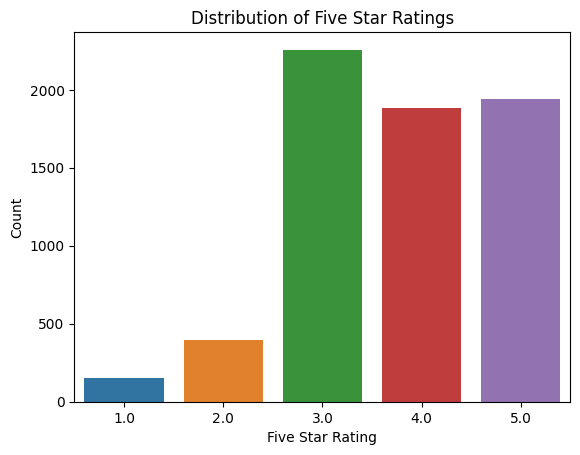

In [ ]:
sns.countplot(data=df_combined, x='Five Star')
plt.title('Distribution of Five Star Ratings')
plt.xlabel('Five Star Rating')
plt.ylabel('Count')
plt.show()


# Comparative analysis with state averages